### [POC 3]  NGLY1 deficiency patient extraction

This analysis attempts to extract as many details as possible about NGLY1 patients from 2 full-text papers on the subject.

See https://github.com/eric-czech/ngly1-gpt/issues/1 for more details and a summary of results.

In [1]:
%load_ext autoreload
%autoreload 2
import io
import sys
import pprint
import pandas as pd
import matplotlib.pyplot as plt
from ngly1_gpt import utils, llm, doc
from IPython.display import Image, HTML
import logging
logging.basicConfig(level=logging.INFO, stream=sys.stdout)
pd.set_option("display.max_colwidth", None, "display.max_rows", 400, "display.max_columns", None)

### Prompts

Initial detail extraction prompt:

In [2]:
print((utils.get_paths().prompts / "patient_extraction_1.txt").read_text())

Text will be provided that contains information from a published, biomedical research article about {disease}.  Extract details about the patients discussed in this text: 

--- BEGIN TEXT ---
{text}
--- END TEXT ---

Requirements:

- Exclude any patients where context dictates that they do NOT have {disease}, e.g. when {disease} patients are compared to similar patients with other diseases.
- Extract as much information as possible about each patient including associated genotypes, phenotypes, physical or behavioral traits, demographics, lab measurements, treatments, family histories or anything else of clinical and/or biological relevance.
- Extract this information in CSV format with the following headers:
  - `patient_id`: Identifying information for the patient within the context of the article
    - When a single patient is unambiguously referenced by an identifier, this must be equal to that identifier; typically an integer, anonymized name or database identifier
    - When ALL p

Schema inference prompt:

In [3]:
print((utils.get_paths().prompts / "patient_extraction_2.txt").read_text())

The following list of details contains specific characteristics of rare disease patients:

--- BEGIN DETAILS LIST ---
{details}
--- END DETAILS LIST ---

Define a schema that would best model the properties of these patients. 

This schema should include, but not be limited to, properties like genotypes, mutations, assays, sequencing centers/platforms, phenotypes, symptoms, comorbitities, diseases, physical or behavioral traits, demographics, scores, lab measurements, treatments, family histories or anything else of clinical, biological, experimental or administrative relevance.

Requirements for the resulting schema:
- Describe this schema using the JSON Schema specification for Python, as implemented by the `jsonschema` library
- Include `doc_id`, `patient_accession` and `extra_info` fields using the definition provided in the stub schema below
- Use snake case for ALL field names, with only lower case, alphanumeric characters and underscores
- Assume that fields with a plural connot

Record extraction prompt:

In [4]:
print((utils.get_paths().prompts / "patient_extraction_3.txt").read_text())

The following table in pipe-delimited CSV format contains details about individual rare disease patients:

--- BEGIN PATIENT DETAILS ---
{details}
--- END PATIENT DETAILS ---

Extract these details into individual records matching the following JSON Schema:

--- BEGIN JSON SCHEMA ---
{schema}
--- END JSON SCHEMA ---

Requirements:

- Create exactly one output record for every input record
- Extract ALL details for each patient into the provided schema 
- If any one piece of information for a patient does not apply to a field in the schema well, summarize that information concisely and add it as an element in the `extra_info` field
  - Each element in `extra_info` must be no more than 10 words
  - There must be no more than 30 elements in `extra_info` for a given record
  - Avoid using `extra_info` as much as possible; prioritize the more structured fields instead
- STANDARDIZE the values of fields as much as possible such that they are consistent and directly comparable between patient

### Execution

The prompt was run for all paper chunks via a command like:

```bash
PYTHONPATH="$(pwd)" python ngly1_gpt/cli.py extract_patients \
  --output-filename=patients.tsv 2>&1 | tee data/logs/extract_patients.log.txt
PYTHONPATH="$(pwd)" python ngly1_gpt/cli.py infer_patients_schema \
  --sampling-rate=.75 --input-filename=patients.tsv \
  --output-filename=patients.schema.json 2>&1 | tee data/logs/infer_patients_schema.log.txt
PYTHONPATH="$(pwd)" python ngly1_gpt/cli.py export_patients \
  --input-data-filename=patients.tsv \
  --input-schema-filename=patients.schema.json \
  --output-filename=patients.json 2>&1 | tee data/logs/export_patients.log.txt
PYTHONPATH="$(pwd)" python ngly1_gpt/cli.py calculate_phenotype_frequency \
  --input-patient-details-filename=patients.tsv \
  --input-patient-records-filename=patients.json \
  --output-filename=phenotype_frequencies.tsv 2>&1 | tee data/logs/calculate_phenotype_frequency.log.txt
```

The logs for these extractions showing all prompts and results are in [data/logs](data/logs).

### Analysis

Example "details" records from initial extraction:

In [5]:
patients = pd.read_csv(utils.get_paths().output_data / "patients.tsv", sep="\t")
patients.info()
patients.sample(n=15, random_state=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   patient_id         203 non-null    object
 1   patient_accession  202 non-null    object
 2   external_study     15 non-null     object
 3   details            203 non-null    object
 4   doc_id             203 non-null    object
 5   doc_filename       203 non-null    object
dtypes: object(6)
memory usage: 9.6+ KB


,patient_id,patient_accession,external_study,details,doc_id,doc_filename
18,Patient 6,6,NaN,"Patient 6 is a 0.9 month old Caucasian female. She does not have consanguinity. Her mutations are c.1201A>T(p. R401X)/c.1201A>T(p.R401X). She has IUGR, brain imaging abnormalities, microcephaly, global developmental delay, hypotonia, movement disorder, EEG abnormalities, decreased DTRs, alacrima/hypolacrima, elevated liver transaminases, liver storage or vacuolization, and constipation.",PMC4243708,PMC4243708.txt
45,Patients 5 and 6,5,NaN,Significant brain disease was noted on autopsy in Patient 5 who was found to have pathological changes consistent with hypoxic-ischemic encephalopathy (HIE).,PMC4243708,PMC4243708.txt
33,Patient 2,2,NaN,"Patient 2 underwent Whole Exome Sequencing (WES) at Baylor College of Medicine Whole Genome Laboratory, which revealed a homozygous mutation in exon 9 of the NGLY1 gene, denoted as c.1370dupG or p.R458fs. Both parents were confirmed to be heterozygous carriers by Sanger sequencing. The mutation causes a frame shift in codon 458, causing insertion of 13 incorrect residues before a stop codon is introduced towards the end of exon 9. The mutation was not seen in any of 3321 other subjects sequenced at Duke, nor was it seen in 6503 subjects on the Exome Variant Server (NHLBI GO Exome Sequencing Project (ESP), Seattle, WA).",PMC4243708,PMC4243708.txt
37,Patient 4,4,NaN,"Sanger sequencing (Duke University) detected a homozygous nonsense mutation, p.R401X, at position 3:25775422 (hg19) in transcript ENST00000280700. At the cDNA level this is c.1201A>T in exon 8 of NGLY1. This finding was confirmed in a CLIA- certified laboratory (GeneDx).",PMC4243708,PMC4243708.txt
109,ALL,ALL,NaN,"Increased atrophy correlated with worsening of all functional measurements, including IQ or DQ, Vineland assessments, and Nijmegen scores. Brain volume also directly correlated with CSF levels of 5-HIAA, tetrahydrobiopterin, and 5-HVA.",PMC7477955,PMC7477955.txt
90,ALL,ALL,NaN,The total foot length was < 3rd percentile in all 12 individuals.,PMC7477955,PMC7477955.txt
5,Patient 6,6,University of British Columbia,Exome sequencing was performed using the Illumina HiSeq2000 platform and the Agilent SureSelect Human All Exon 50 Mb Kit.,PMC4243708,PMC4243708.txt
124,SOME,SOME,NaN,Ten of twelve individuals had some degree of constipation.,PMC7477955,PMC7477955.txt
12,ALL,ALL,NaN,"All patients had global developmental delay, a movement disorder, and hypotonia. Other common findings included hypo- or alacrima (7/8), abnormal brain imaging (7/8), EEG abnormalities (7/8), elevated liver transaminases (6/7), microcephaly (6/8), diminished reflexes (6/8), hepatocyte cytoplasmic storage material or vacuolization (5/6), seizures (4/8), and abnormal nerve conduction (3/3). Two of the patients died prematurely at 9 months and 5 years of age.",PMC4243708,PMC4243708.txt
153,1,1,NaN,Patient 1 had onset of seizures at 0.7 years with initial type being Infantile Spasms. No seizures per day were reported. The patient was on Levetiracetam medication. No epileptiform discharge localization was observed. Background slowing was present with a PDR of 7 Hertz. Anterior/Posterior gradient was present.,PMC7477955,PMC7477955.txt


In [6]:
(
    patients[['doc_id', 'patient_id', 'patient_accession']]
    .value_counts()
    .reset_index()
)

,doc_id,patient_id,patient_accession,count
0,PMC7477955,ALL,ALL,50
1,PMC4243708,ALL,ALL,11
2,PMC7477955,SOME,SOME,11
3,PMC4243708,Patient 3,3,8
4,PMC7477955,6,6,7
5,PMC4243708,Patient 2,2,6
6,PMC7477955,11,11,6
7,PMC7477955,7,7,6
8,PMC7477955,2,2,6
9,PMC7477955,8,8,6


Finalized patient data after extraction/aggregation into shared schema:

In [7]:
patient_records = pd.read_json(utils.get_paths().output_data / "patients.json", lines=True)
patient_records.info()
with pd.option_context("display.max_colwidth", 100):
    display(patient_records.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   doc_id             22 non-null     object 
 1   patient_accession  22 non-null     object 
 2   extra_info         22 non-null     object 
 3   age                21 non-null     float64
 4   gender             21 non-null     object 
 5   race               9 non-null      object 
 6   consanguinity      9 non-null      float64
 7   mutations          22 non-null     object 
 8   phenotypes         16 non-null     object 
 9   neuropathy         15 non-null     object 
 10  seizure_info       15 non-null     object 
 11  lab_measurements   16 non-null     object 
 12  family_history     7 non-null      object 
 13  scores             19 non-null     object 
 14  sequencing_info    10 non-null     object 
 15  disease_info       22 non-null     object 
dtypes: float64(2), object(14)
me

,doc_id,patient_accession,extra_info,age,gender,race,consanguinity,mutations,phenotypes,neuropathy,seizure_info,lab_measurements,family_history,scores,sequencing_info,disease_info
0,PMC4243708,1,"[Exome sequencing performed using Illumina HiSeq2000, Agilent SureSelect Human All Exon 50 Mb Ki...",5.0,male,Caucasian,0.0,"[c.C1891del (p.Q631S), c.1201A>T(p.R401X)]","[brain imaging abnormalities, global developmental delay, hypotonia, movement disorder, EEG abno...",{},{},{},[],{},"{'sequencing_center': 'Research protocol', 'sequencing_platform': 'Illumina HiSeq2000', 'coverag...","{'disease_name': 'Not specified', 'allele_1_mutation': 'c.C1891del (p.Q631S)', 'allele_2_mutatio..."
1,PMC4243708,2,"[WES performed on a clinical basis, Born at 39 weeks of gestation via Cesarean section, Intraute...",20.0,female,Caucasian,1.0,"[c.1370dupG(p.R458fs), c.1370dupG(p.R458fs)]","[IUGR, microcephaly, global developmental delay, hypotonia, movement disorder, EEG abnormalities...",{},{},{},[],{},"{'sequencing_center': 'Baylor College of Medicine Whole Genome Laboratory', 'sequencing_platform...","{'disease_name': 'Not specified', 'allele_1_mutation': 'c.1370dupG(p.R458fs)', 'allele_2_mutatio..."
2,PMC4243708,3,"[Sequenced using both Illumina HiSeq2000 and Complete Genomics platforms, Variants in Illumina-s...",4.0,female,Caucasian,0.0,"[c.1205_1207del(p.402_403del), c.1570C>(p. R524X)]","[brain imaging abnormalities, microcephaly, global developmental delay, hypotonia, movement diso...",{},{},{},[],{},"{'sequencing_center': 'Baylor College of Medicine and Stanford University', 'sequencing_platform...","{'disease_name': 'Not specified', 'allele_1_mutation': 'c.1205_1207del(p.402_403del)', 'allele_2..."
3,PMC4243708,4,"[Delivered by Cesarean section at 38 weeks, Positive pregnancy history for IUGR and oligohydramn...",2.0,male,Caucasian,0.0,[c.1201A>T(p. R401X)c.1201A>T(pR401X)],"[IUGR, brain imaging abnormalities, global developmental delay, hypotonia, movement disorder, EE...",None,None,None,None,None,"{'sequencing_center': 'GeneDx, Gaithersburg, Maryland', 'sequencing_platform': 'Sanger sequencing'}","{'disease_name': 'NGLY1 deficiency', 'allele_1_mutation': 'c.1201A>T(p.R401X)', 'allele_2_mutati..."
4,PMC4243708,5,"[Born at term following complicated pregnancy, Positive second trimester serum screening for tri...",0.5,male,Caucasian,0.0,[c.1201A>T(p. R401X)/c.1201A>T(p.R401X)],"[IUGR, brain imaging abnormalities, microcephaly, global developmental delay, hypotonia, movemen...",None,None,None,None,None,{'sequencing_center': 'Illumina HiSeq2000 platform and the Agilent SureSelect Human All Exon 50 ...,"{'disease_name': 'NGLY1 deficiency', 'allele_1_mutation': 'c.1201A>T(p.R401X)', 'allele_2_mutati..."


Presence of fields:

In [8]:
(
    patient_records
    .groupby(['doc_id', 'patient_accession'])
    .apply(lambda g: 
        g.notnull().drop(columns=['doc_id', 'patient_accession'])
        .applymap(lambda v: 'X' if v else '')
    )
)

extra_info age gender race consanguinity  \
doc_id     patient_accession                                               
PMC4243708 1                 0           X   X      X    X             X   
           2                 1           X   X      X    X             X   
           3                 2           X   X      X    X             X   
           4                 3           X   X      X    X             X   
           5                 4           X   X      X    X             X   
           6                 5           X   X      X    X             X   
           7                 6           X   X      X    X             X   
           8                 7           X   X      X    X             X   
           ALL               8           X                                 
PMC7477955 1                 9           X   X      X                      
           2                 13          X   X      X                      
           3                 14          X   X      X                      
           4                 15          X   X      X                      
           5                 16          X   X      X                      
           6                 17          X   X      X                      
           7                 18          X   X      X                      
           8                 19          X   X      X                      
           9                 20          X   X      X                      
           10                10          X   X      X                      
           11                11          X   X      X                      
           12                12          X   X      X                      
           ALL               21          X   X      X    X             X   

                                mutations phenotypes neuropathy seizure_info  \
doc_id     patient_accession                                                   
PMC4243708 1                 0          X          X          X            X   
           2                 1          X          X          X            X   
           3                 2          X          X          X            X   
           4                 3          X          X                           
           5                 4          X          X                           
           6                 5          X          X                           
           7                 6          X          X          X            X   
           8                 7          X          X          X            X   
           ALL               8          X          X          X            X   
PMC7477955 1                 9          X          X          X            X   
           2                 13         X                                      
           3                 14         X                                      
           4                 15         X                                      
           5                 16         X                     X            X   
           6                 17         X                     X            X   
           7                 18         X          X          X            X   
           8                 19         X          X          X            X   
           9                 20         X          X          X            X   
           10                10         X          X          X            X   
           11                11         X          X          X            X   
           12                12         X                                      
           ALL               21         X          X          X            X   

                                lab_measurements family_history scores  \
doc_id     patient_accession                                             
PMC4243708 1                 0                 X              X      X   
           2                 1                 X              X 

In [9]:
study_size = (
    patient_records
    .pipe(lambda df: df[pd.to_numeric(df['patient_accession'], errors='coerce').notnull()])
    .groupby(['doc_id'])['patient_accession']
    .nunique()
)
study_size

doc_id
PMC4243708     8
PMC7477955    12
Name: patient_accession, dtype: int64

##### Results ([PMC7477955](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8997433))

In [10]:
with pd.option_context('display.max_colwidth', 500):
    display(
        patient_records
        .pipe(lambda df: df[df['doc_id'] == 'PMC7477955'])
        .pipe(lambda df: df[df['patient_accession'] != 'ALL'])
        .sample(n=5, random_state=0).T
    )

,15,20,13,19,11
doc_id,PMC7477955,PMC7477955,PMC7477955,PMC7477955,PMC7477955
patient_accession,4,9,2,8,11
extra_info,"[Patient 4 never had seizures, No information on medication, epileptiform discharge localization, background slowing, PDR, and Anterior/Posterior gradient was determined, Patient 4's nerve conduction study (NCS), electromyogram (EMG), and quantitative sweat analysis (QSWEAT) results were not determined (ND)]","[Included in previous clinical publications, Distal upper and lower extremities have developed a flexion contracture at the hands and feet, Irregular action-induced jerking movements are elicited while reaching, Gaze is conjugate, Visual pursuit is normal and there is generalized arreflexia, Muscle wasting notable throughout, especially in the lower extremities likely secondary to peripheral neuropathy]","[Individual #2 had slight cerebellar atrophy., Patient 2 had onset of seizures between 0.2-0.7 years with initial type being Infantile Spasms., No seizures per day were reported., The patient was on Valproate medication., Multifocal epileptiform discharge localization was observed., Mild background slowing was present with a PDR of 5-6 Hertz., Anterior/Posterior gradient was poorly formed., Patient 2 has peripheral neuropathy (PN) in sensory and motor nerves., Demyelinative conduction veloci...","[Sibling of patient 7, Has private cryptic splice site mutation (c.930C>T) and a private nonsense mutation (c.622C>T)]","[Sibling of patient 3, Included in previous clinical publications, Atrophy measurably worse after 20-month interval, Chronic neurogenic and distal leg active denervation]"
age,5.0,16.0,4.0,10.0,18.0
gender,female,male,male,male,female
race,None,None,None,None,None
consanguinity,NaN,NaN,NaN,NaN,NaN
mutations,"[c.931G>A (p.E311K), c.730T>C (p.W244R)]","[c.347C>G (p.S116*), c.881+5G>T (IVS5+5G>T)]","[c.1201A>T (p.R401*), c.1201A>T (p.R401*)]","[c.622C>T (p.Q208*), c.930C>T (p.G310G (splice site))]","[c.1201A>T (p.R401*), c.1201A>T (p.R401*)]"
phenotypes,None,[NGLY1 deficiency],None,[NGLY1 deficiency],[NGLY1 deficiency]
neuropathy,None,"{'sensory_nerves': True, 'motor_nerves': True, 'conduction_velocity': 'demyelinative', 'emg_findings': 'chronic neurogenic and active denervation in limbs', 'qsweat_findings': 'present in arm but absent in ankle'}",None,"{'sensory_nerves': True, 'motor_nerves': True, 'conduction_velocity': 'borderline slow', 'emg_findings': 'mild chronic neurogenic', 'qsweat_findings': 'present in both arm and ankle'}","{'sensory_nerves': True, 'motor_nerves': True, 'conduction_velocity': 'demyelinative', 'qsweat_findings': 'present'}"


In [11]:
pprint.pprint(
    patient_records
    .pipe(lambda df: df[df['doc_id'] == 'PMC7477955'])
    .pipe(lambda df: df[df['patient_accession'] == 1])
    .assign(extra_info=lambda df: df['extra_info'].apply(lambda v: " ".join(v)))
    .iloc[0].to_dict(),
    width=120
)

{'age': 3.0,
 'consanguinity': nan,
 'disease_info': {'allele_1_mutation': 'c.953T>C (p.L318P)',
                  'allele_2_mutation': 'c.1169G>C (p.R390P)',
                  'disease_name': 'NGLY1 deficiency'},
 'doc_id': 'PMC7477955',
 'extra_info': 'Slight cerebellar atrophy No epileptiform discharge localization Anterior/Posterior gradient present '
               'Action minipolymyoclonus observed',
 'family_history': None,
 'gender': 'male',
 'lab_measurements': {'5hiaa_level': '146 nM',
                      'albumin_level': '10 mg/dL',
                      'amino_acids': 'normal',
                      'bh4_level': '9 nM',
                      'csf_serum_albumin_quotient': 2.9,
                      'hva_level': '234 nM',
                      'lactate_level': '0.9 mM',
                      'neopterin_level': '21 nM',
                      'protein_level': '19 mg/dL'},
 'mutations': ['c.953T>C (p.L318P)', 'c.1169G>C (p.R390P)'],
 'neuropathy': {'conduction_velocity': 'slow

Replication of [Table 1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7477955/table/T1) (PMC7477955)

A manual review of all 9 (fields) x 12 (patients) = 108 cells shows 0 errors in this extracted table.  This includes character by character checks for the gene/protein variants.

In [12]:
(
    patient_records
    .pipe(lambda df: df[df['doc_id'] == 'PMC7477955'])
    .pipe(lambda df: df[df['patient_accession'] != 'ALL'])
    .assign(allele_1_mutation=lambda df: df['disease_info'].apply(lambda v: v.get('allele_1_mutation')).str.extract(r'(c\..*?\s+)'))
    .assign(allele_1_protein=lambda df: df['disease_info'].apply(lambda v: v.get('allele_1_mutation')).str.extract(r'\((.*)\)'))
    .assign(allele_2_mutation=lambda df: df['disease_info'].apply(lambda v: v.get('allele_2_mutation')).str.extract(r'(c\..*?\s+)'))
    .assign(allele_2_protein=lambda df: df['disease_info'].apply(lambda v: v.get('allele_2_mutation')).str.extract(r'\((.*)\)'))
    .pipe(lambda df: pd.concat([df, pd.DataFrame(df['scores'].to_list(), index=df.index)], axis=1))
    .assign(age=lambda df: df['age'].astype(int), patient_accession=lambda df: df['patient_accession'].astype(int))
    .sort_values('patient_accession')
    .reset_index(drop=True)
    .filter(regex='doc_id|patient_accession|age|gender|allele|_score|iq')
    
)

,doc_id,patient_accession,age,gender,allele_1_mutation,allele_1_protein,allele_2_mutation,allele_2_protein,nijmegen_score,vineland_score,iq_dq
0,PMC7477955,1,3,male,c.953T>C,p.L318P,c.1169G>C,p.R390P,14.0,62.0,NaN
1,PMC7477955,2,4,male,c.1201A>T,p.R401*,c.1201A>T,p.R401*,33.0,52.0,25.0
2,PMC7477955,3,4,female,c.1201A>T,p.R401*,c.1201A>T,p.R401*,34.0,40.0,5.0
3,PMC7477955,4,5,female,c.931G>A,p.E311K,c.730T>C,p.W244R,33.0,NaN,NaN
4,PMC7477955,5,6,male,c.1604G>A,p.W535*,c.1910delT,p.L637*,25.0,43.0,8.0
5,PMC7477955,6,7,male,c.1891delC,p.Q631S,c.1201A>T,p.R401*,36.0,37.0,5.0
6,PMC7477955,7,8,female,c.622C>T,p.Q208*,c.930C>T,p.G310G (splice site),10.0,98.0,74.0
7,PMC7477955,8,10,male,c.622C>T,p.Q208*,c.930C>T,p.G310G (splice site),9.0,94.0,81.0
8,PMC7477955,9,16,male,c.347C>G,p.S116*,c.881+5G>T,IVS5+5G>T,32.0,28.0,2.0
9,PMC7477955,10,17,female,c.1201A>T,p.R401*,c.1201A>T,p.R401*,25.0,42.0,16.0


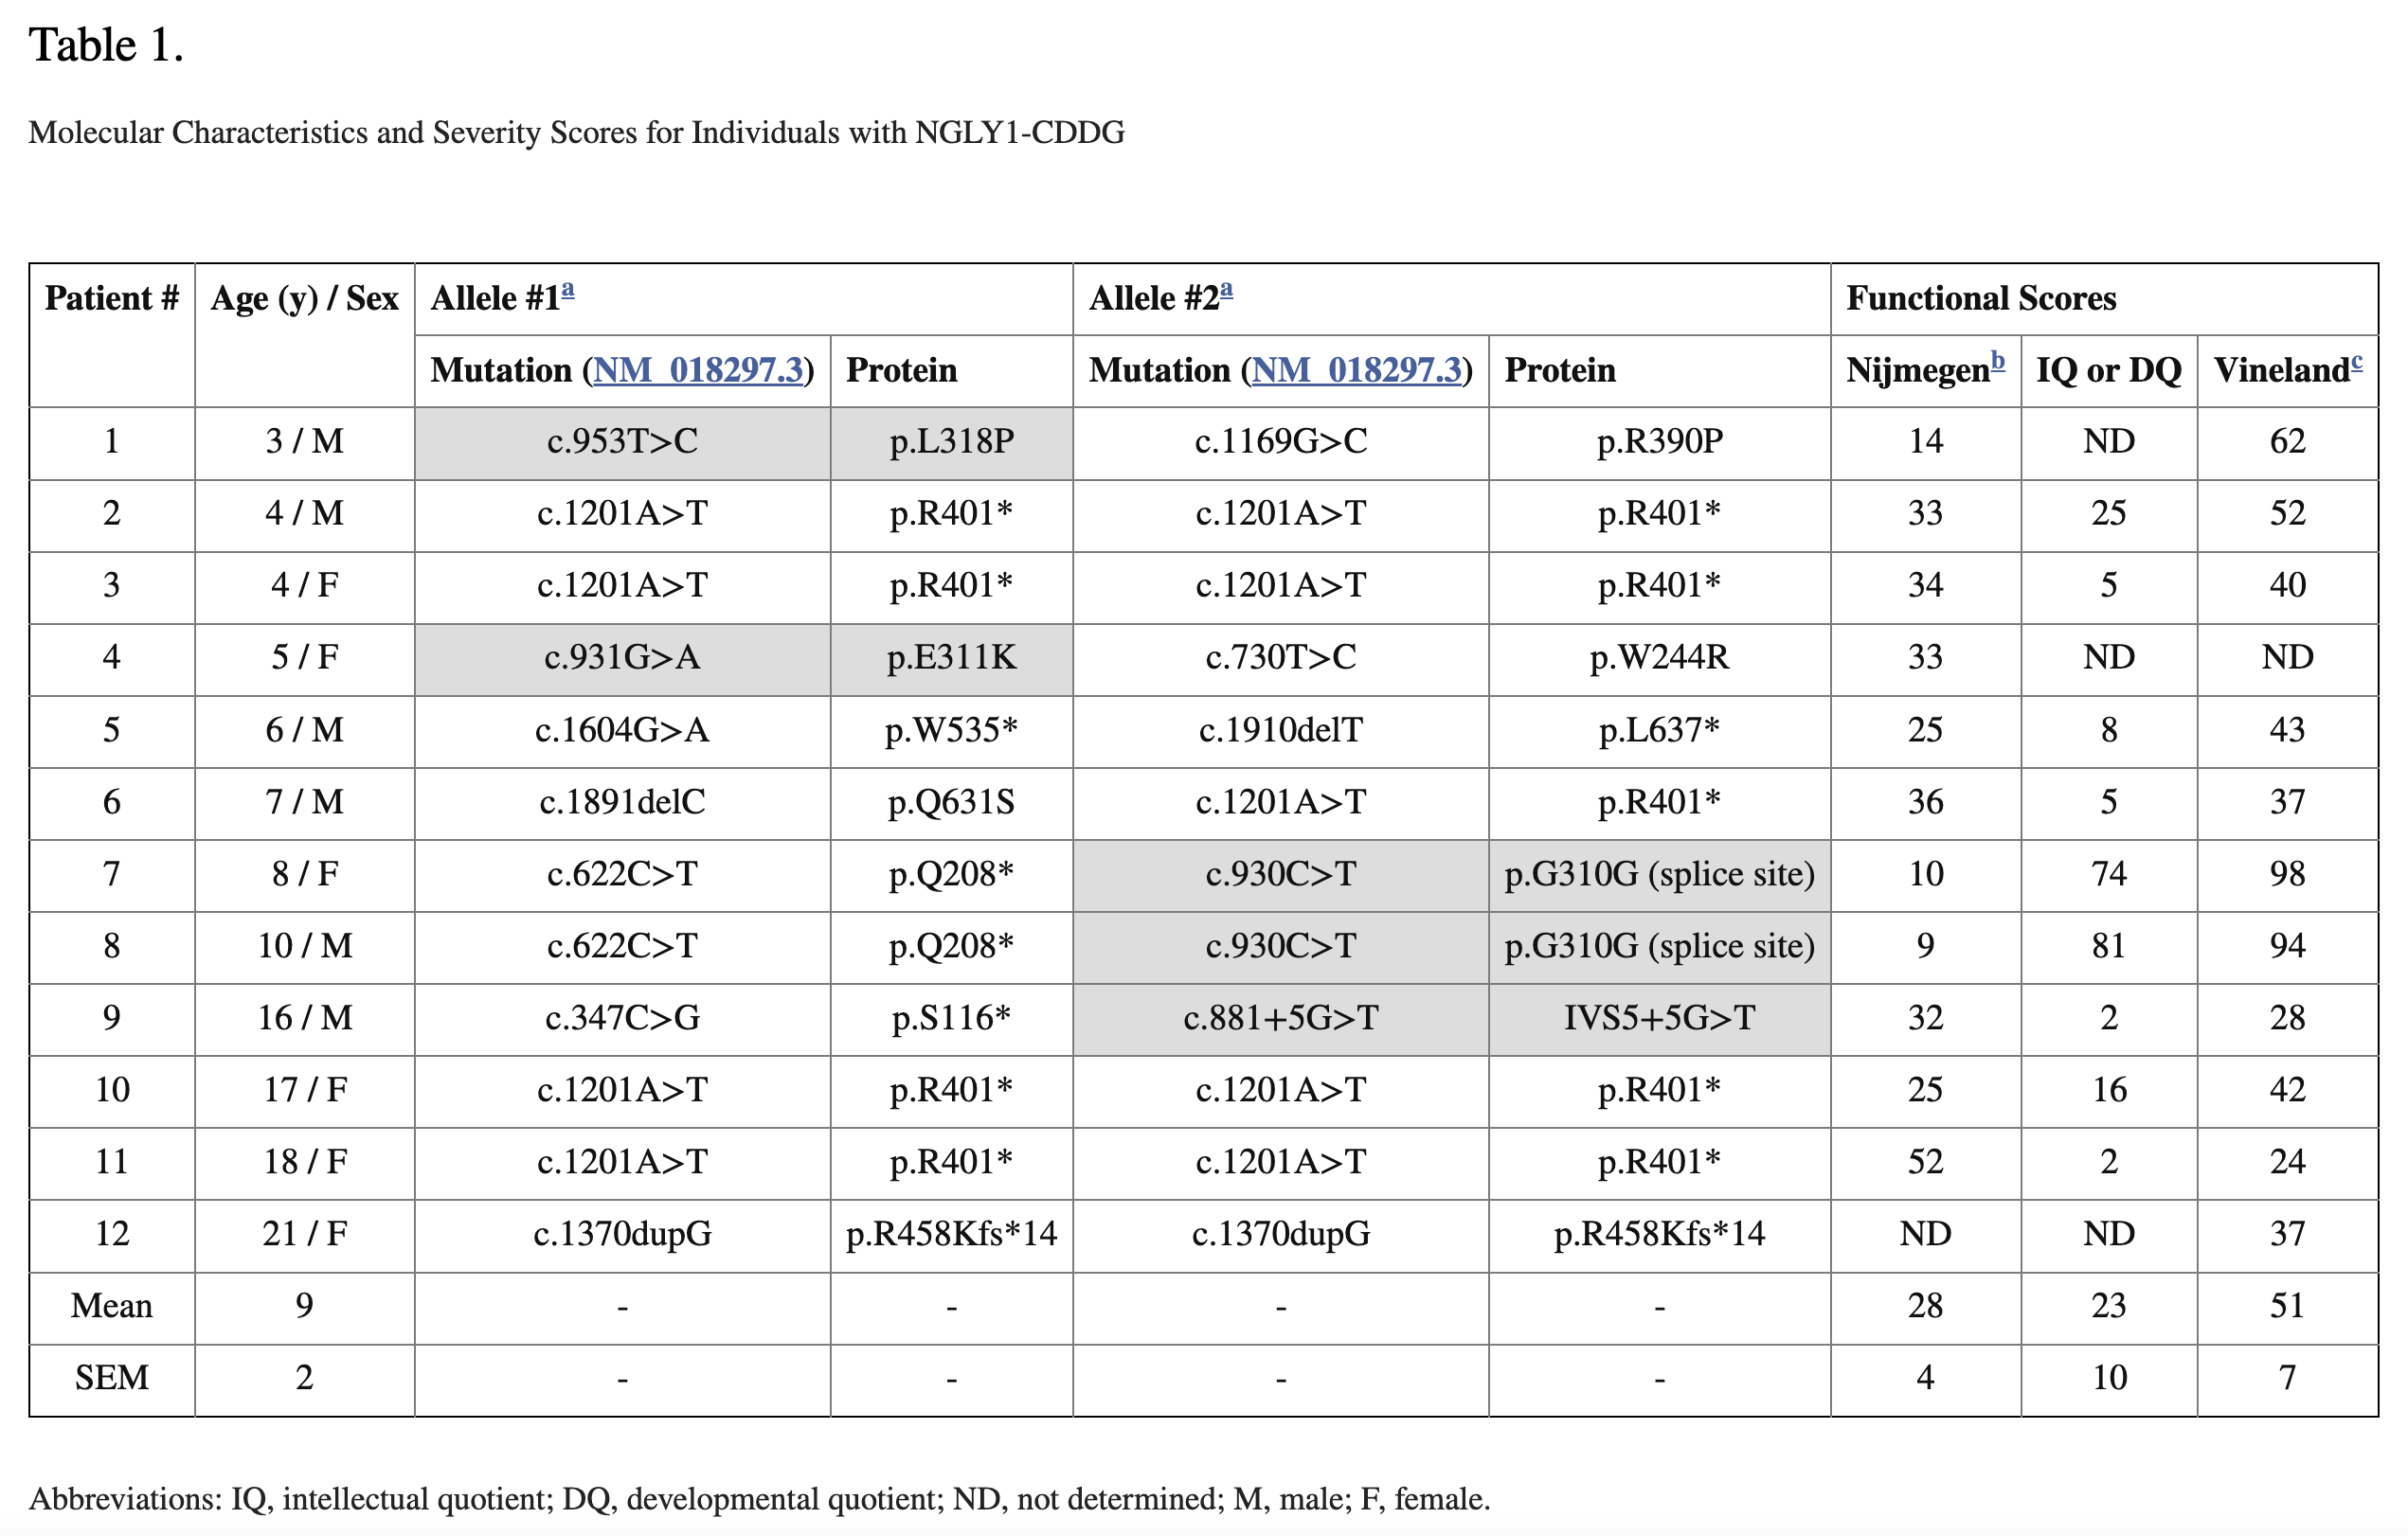

In [13]:
Image("ngly1_gpt/notebooks/images/PMC7477955_table_1.png", width=1000)

Replication of [Table S3](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7477955/bin/NIHMS1623121-supplement-1.pdf) (PMC7477955)

A manual review of all 9 (fields) x 12 (patients) = 108 cells shows 0 errors in this extracted table.

In [14]:
(
    patient_records
    .pipe(lambda df: df[df['doc_id'] == 'PMC7477955'])
    .pipe(lambda df: df[df['patient_accession'] != 'ALL'])
    .filter(regex='doc_id|patient_accession|lab_measurements')
    .assign(patient_accession=lambda df: df['patient_accession'].astype(int))
    .sort_values('patient_accession')
    .pipe(lambda df: pd.concat([df, pd.DataFrame([e or {} for e in df['lab_measurements']], index=df.index)], axis=1))
    .drop(columns=['lab_measurements'])
    
)

,doc_id,patient_accession,protein_level,albumin_level,csf_serum_albumin_quotient,5hiaa_level,hva_level,neopterin_level,bh4_level,lactate_level,amino_acids
9,PMC7477955,1,19 mg/dL,10 mg/dL,2.9,146 nM,234 nM,21 nM,9 nM,0.9 mM,normal
13,PMC7477955,2,8 mg/dL,5 mg/dL,1.6,194 nM,316 nM,22 nM,8 nM,1.7 mM,Glutamic acid
14,PMC7477955,3,12 mg/dL,8 mg/dL,2.4,83 nM,206 nM,17 nM,8 nM,1.3 mM,Glycine
15,PMC7477955,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,PMC7477955,5,11 mg/dL,6 mg/dL,2.1,115 nM,316 nM,11 nM,10 nM,not determined,normal
17,PMC7477955,6,5 mg/dL,3 mg/dL,0.9,163 nM,385 nM,14 nM,10 nM,1.2 mM,normal
18,PMC7477955,7,13 mg/dL,9 mg/dL,2.5,169 nM,327 nM,17 nM,13 nM,1.3 mM,Glutamine
19,PMC7477955,8,40 mg/dL,24 mg/dL,7.1,195 nM,376 nM,12 nM,18 nM,1.1 mM,normal
20,PMC7477955,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,PMC7477955,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


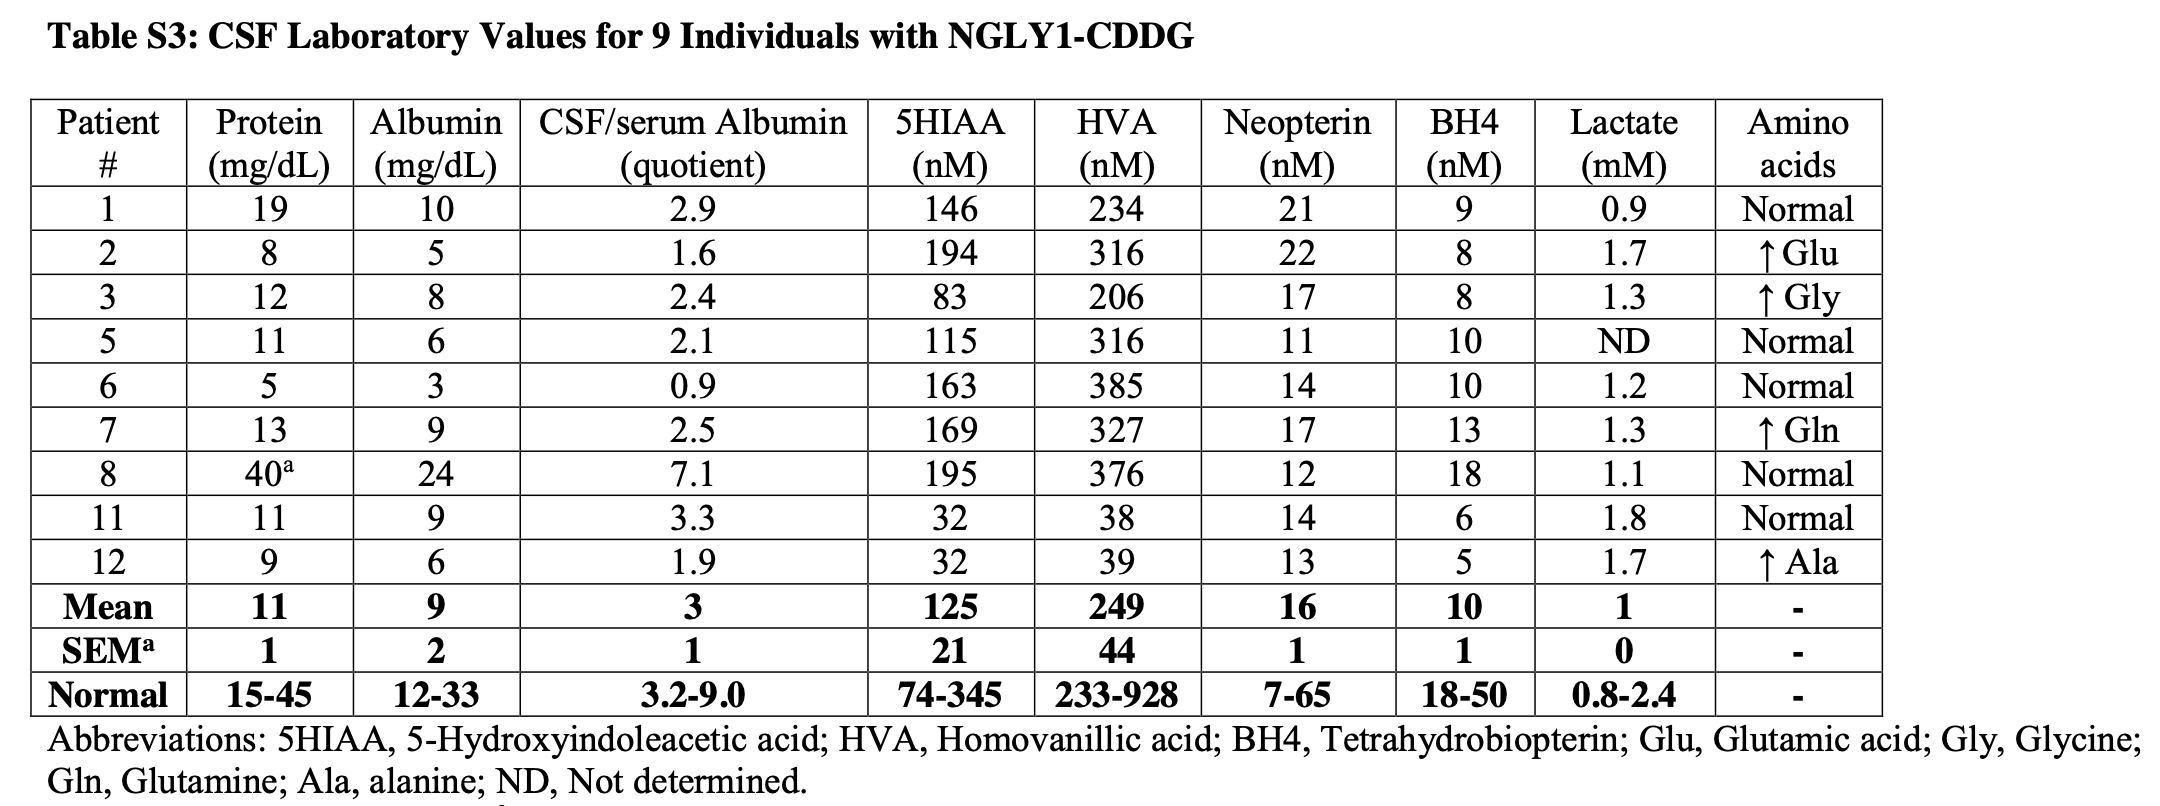

In [15]:
Image("ngly1_gpt/notebooks/images/PMC7477955_table_S3.png", width=1200)

##### Results ([PMC4243708](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4243708))

In [16]:
patient_records.pipe(lambda df: df[df['doc_id'] == 'PMC4243708']).sample(5, random_state=0).T

,7,2,1,4,8
doc_id,PMC4243708,PMC4243708,PMC4243708,PMC4243708,PMC4243708
patient_accession,8,3,2,5,ALL
extra_info,"[Older sister of Subject 7, Born at term via Cesarean section for decreased fetal movement and bradycardia, Prenatal history was significant for IUGR, Cyanosis at birth and required resuscitation, Anal stenosis requiring dilatation was noted in the first week of life, Seizures developed at age 11 years and she lost all mobility, Inability to close her eyes completely during sleep, Chronic conjunctivitis, Corneal clouding, Hypolacrima, Strabismus, Hearing impairment, Gastro-esophageal reflux, Chronic constipation, Severe scoliosis, Talipes equinovarus]","[Sequenced using both Illumina HiSeq2000 and Complete Genomics platforms, Variants in Illumina-sequenced reads were called using both the Hugeseq and Real Time Genomics pipelines, Complete Genomics variants were identified by their own variant callers, DNA was capture- sequenced using a commercially developed capture reagent (VCRome2), Average coverage of 80× with >90% of targeted bases at 20× coverage or higher, No IUGR, Born via Cesarean section at term due to a non-reassuring fetal heart tracing, Monitored in the NICU due to poor feeding and lethargy, Pregnancy complicated by a positive second trimester screen noting increased risk for Smith-Lemli Opitz syndrome (SLOS) and trisomy 18, Karyotype on amniocentesis was normal, Hyperbilirubinemia treated with phototherapy, Elevated liver transaminases and transient thrombocytopenia as a neonate, Global developmental delay, acquired microcephaly, bilateral exotropia, hypotonia, constipation, and intermittent mild lactic acidemia in infancy, Parents noticed that she did not make tears when crying at age 1, Intermittent chalazions, but no corneal scarring, Staring spells lasting up to 15 seconds at approximately age 1 year, Extrapyramidal movement disorder consisting of asynchronous myoclonic jerks of the limbs and shoulders and subtle choreoathetotic movements of the hands and fingers developed by age 17 months, Ambulates unassisted at 4 years, Communicates with vocalizations, gestures and use of a speech-generating device, WES and whole-genome sequencing performed using research protocols at Baylor College of Medicine and Stanford University, Mutations in NGLY1 that followed a compound heterozygous inheritance pattern were identified, Stop gain mutation caused by a G>A mutation at position 3:25761670 (hg19) resulting in p.R542X was identified in both the father and daughter, 3 base pair in-frame deletion TCC> beginning at position 3:25775416 (hg19) was identified in both the mother and daughter, Additional G>T mutation resulting in a heterozygous SMP at position 3:25777564 was identified in the daughter, mother and father, Moderate reduction in mitochondrial DNA content was identified in a liver sample]","[WES performed on a clinical basis, Born at 39 weeks of gestation via Cesarean section, Intrauterine growth retardation and abnormal appearing placenta, Hypotonia, developmental delay and elevated liver transaminases noted at 4 months, Intention tremor and involuntary movements of neck, hands and arm observed at 4 years, Ocular apraxia, distal tapering of hands and feet, and diminished deep tendon reflexes noted at 5 years, Marked intellectual disabilities and requires total care, Communicates through an electronic speech-generating device, Ambulates with a walker, Whole Exome Sequencing performed at Baylor College of Medicine Whole Genome Laboratory, Homozygous mutation in exon 9 of the NGLY1 gene, Mutation causes a frame shift in codon 458, Mutation not seen in any of 3321 other subjects sequenced at Duke, Mutation not seen in 6503 subjects on the Exome Variant Server]","[Born at term following complicated pregnancy, Positive second trimester serum screening for trisomy 18 and SLOS, Delivered by Cesarean section at 36 weeks, Mild flexion contractures of both knees at birth, Global developmental delay and constant m

In [17]:
pprint.pprint(
    patient_records
    .pipe(lambda df: df[df['doc_id'] == 'PMC4243708'])
    .pipe(lambda df: df[df['patient_accession'] == 3])
    .assign(extra_info=lambda df: df['extra_info'].apply(lambda v: " ".join(v)))
    .iloc[0].to_dict(),
    width=120
)

{'age': 4.0,
 'consanguinity': 0.0,
 'disease_info': {'allele_1_mutation': 'c.1205_1207del(p.402_403del)',
                  'allele_2_mutation': 'c.1570C>(p. R524X)',
                  'disease_name': 'Not specified'},
 'doc_id': 'PMC4243708',
 'extra_info': 'Sequenced using both Illumina HiSeq2000 and Complete Genomics platforms Variants in Illumina-sequenced '
               'reads were called using both the Hugeseq and Real Time Genomics pipelines Complete Genomics variants '
               'were identified by their own variant callers DNA was capture- sequenced using a commercially developed '
               'capture reagent (VCRome2) Average coverage of 80× with >90% of targeted bases at 20× coverage or '
               'higher No IUGR Born via Cesarean section at term due to a non-reassuring fetal heart tracing Monitored '
               'in the NICU due to poor feeding and lethargy Pregnancy complicated by a positive second trimester '
               'screen noting increased ri

Replication of [Table 1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4243708/table/T1) (PMC4243708)

This looks good at a first glance, but after manually inspecting the values it's clear there are a number of mistakes:

- There are 26 phenotypes in the actual table and 24 in the data (missing "ABR abnormalities" and "Strabismus")
- "ND", for "Not Determined", is treated as absent although the key for abbreviations wasn't included so that's somewhat expected
- Specific mistakes by phenotype:
  - elevated AFP: patients 6/7/8 are - in the data but ND in actual table (no NDs seem to be preserved)
  - peripheral neuropathy (1): patient 5 should be +
  - EEG abnormalities (1): Patient 7 should be -
  - decreased DTRs (2): patient 5 should be + and patient 6 -
  - alacrima/hypolacrima (1): patient 6 should be -
  - constipation (1): patient 6 should be -
  - neonatal jaundice (2): patient 1 should be +, patient 5 should be -
  - dysmorphic features (2): patient 4 and 6 are wrong
  - lactic acidosis (3): 3 patients are wrong

This means that the total number of mistakes is roughly = 2 (missing phenotypes) x 8 (patients) + 13 (errors) = 29.

There are 34 (fields including demographics) x 8 (patients) = 272 cells in the actual table so the **error rate** here is ~ 29 / 272 = **10.6%**.

In [18]:
(
    patient_records
    .pipe(lambda df: df[df['doc_id'] == 'PMC4243708'])
    .pipe(lambda df: df[df['patient_accession'] != 'ALL'])
    .assign(allele_1_mutation=lambda df: df['disease_info'].apply(lambda v: v.get('allele_1_mutation')).str.extract(r'(c.*?)(?=\()'))
    .assign(allele_1_protein=lambda df: df['disease_info'].apply(lambda v: v.get('allele_1_mutation')).str.extract(r'\((p\..*)\)'))
    .assign(allele_2_mutation=lambda df: df['disease_info'].apply(lambda v: v.get('allele_2_mutation')).str.extract(r'(c.*?)(?=\()'))
    .assign(allele_2_protein=lambda df: df['disease_info'].apply(lambda v: v.get('allele_2_mutation')).str.extract(r'\((p\..*)\)'))
    .assign(age=lambda df: df['age'].astype(int), patient_accession=lambda df: df['patient_accession'].astype(int))
    .pipe(lambda df: pd.concat([df, 
        pd.DataFrame(df['phenotypes'].apply(lambda v: {k: '+' for k in v}).to_list(), index=df.index)
        .fillna('-')
        .rename(columns=lambda c: f"phenotype ({c})")
    ], axis=1))
    .sort_values('patient_accession')
    .reset_index(drop=True)
    .filter(regex='patient_accession|age|gender|consanguinity|race|allele|phenotype ')
    .set_index('patient_accession')
    .rename_axis('patient_id', axis='index')
    .T
    .pipe(utils.apply, lambda df: print(f'Num cells: {df.size} ({df.shape[0]} x {df.shape[1]})'))
)

Num cells: 256 (32 x 8)


patient_id,1,2,3,4,5,6,7,8
age,5,20,4,2,0,0,3,16
gender,male,female,female,male,male,female,female,female
race,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
consanguinity,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
allele_1_mutation,c.C1891del,c.1370dupG,c.1205_1207del,c.1201A>T,c.1201A>T,c.1201A>T,c.1201A>Y,c1201A>T
allele_1_protein,p.Q631S,p.R458fs,p.402_403del,p.R401X,p.R401X,p.R401X,p. R401X,p. R401X
allele_2_mutation,c.1201A>T,c.1370dupG,c.1570C>,c.1201A>T,c.1201A>T,c.1201A>T,c.1201A>T,c.1201A>T
allele_2_protein,p.R401X,p.R458fs,p. R524X,p.R401X,p.R401X,p.R401X,p.R401X,p.R401X
phenotype (brain imaging abnormalities),+,-,+,+,+,+,-,+
phenotype (global developmental delay),+,+,+,+,+,+,+,+


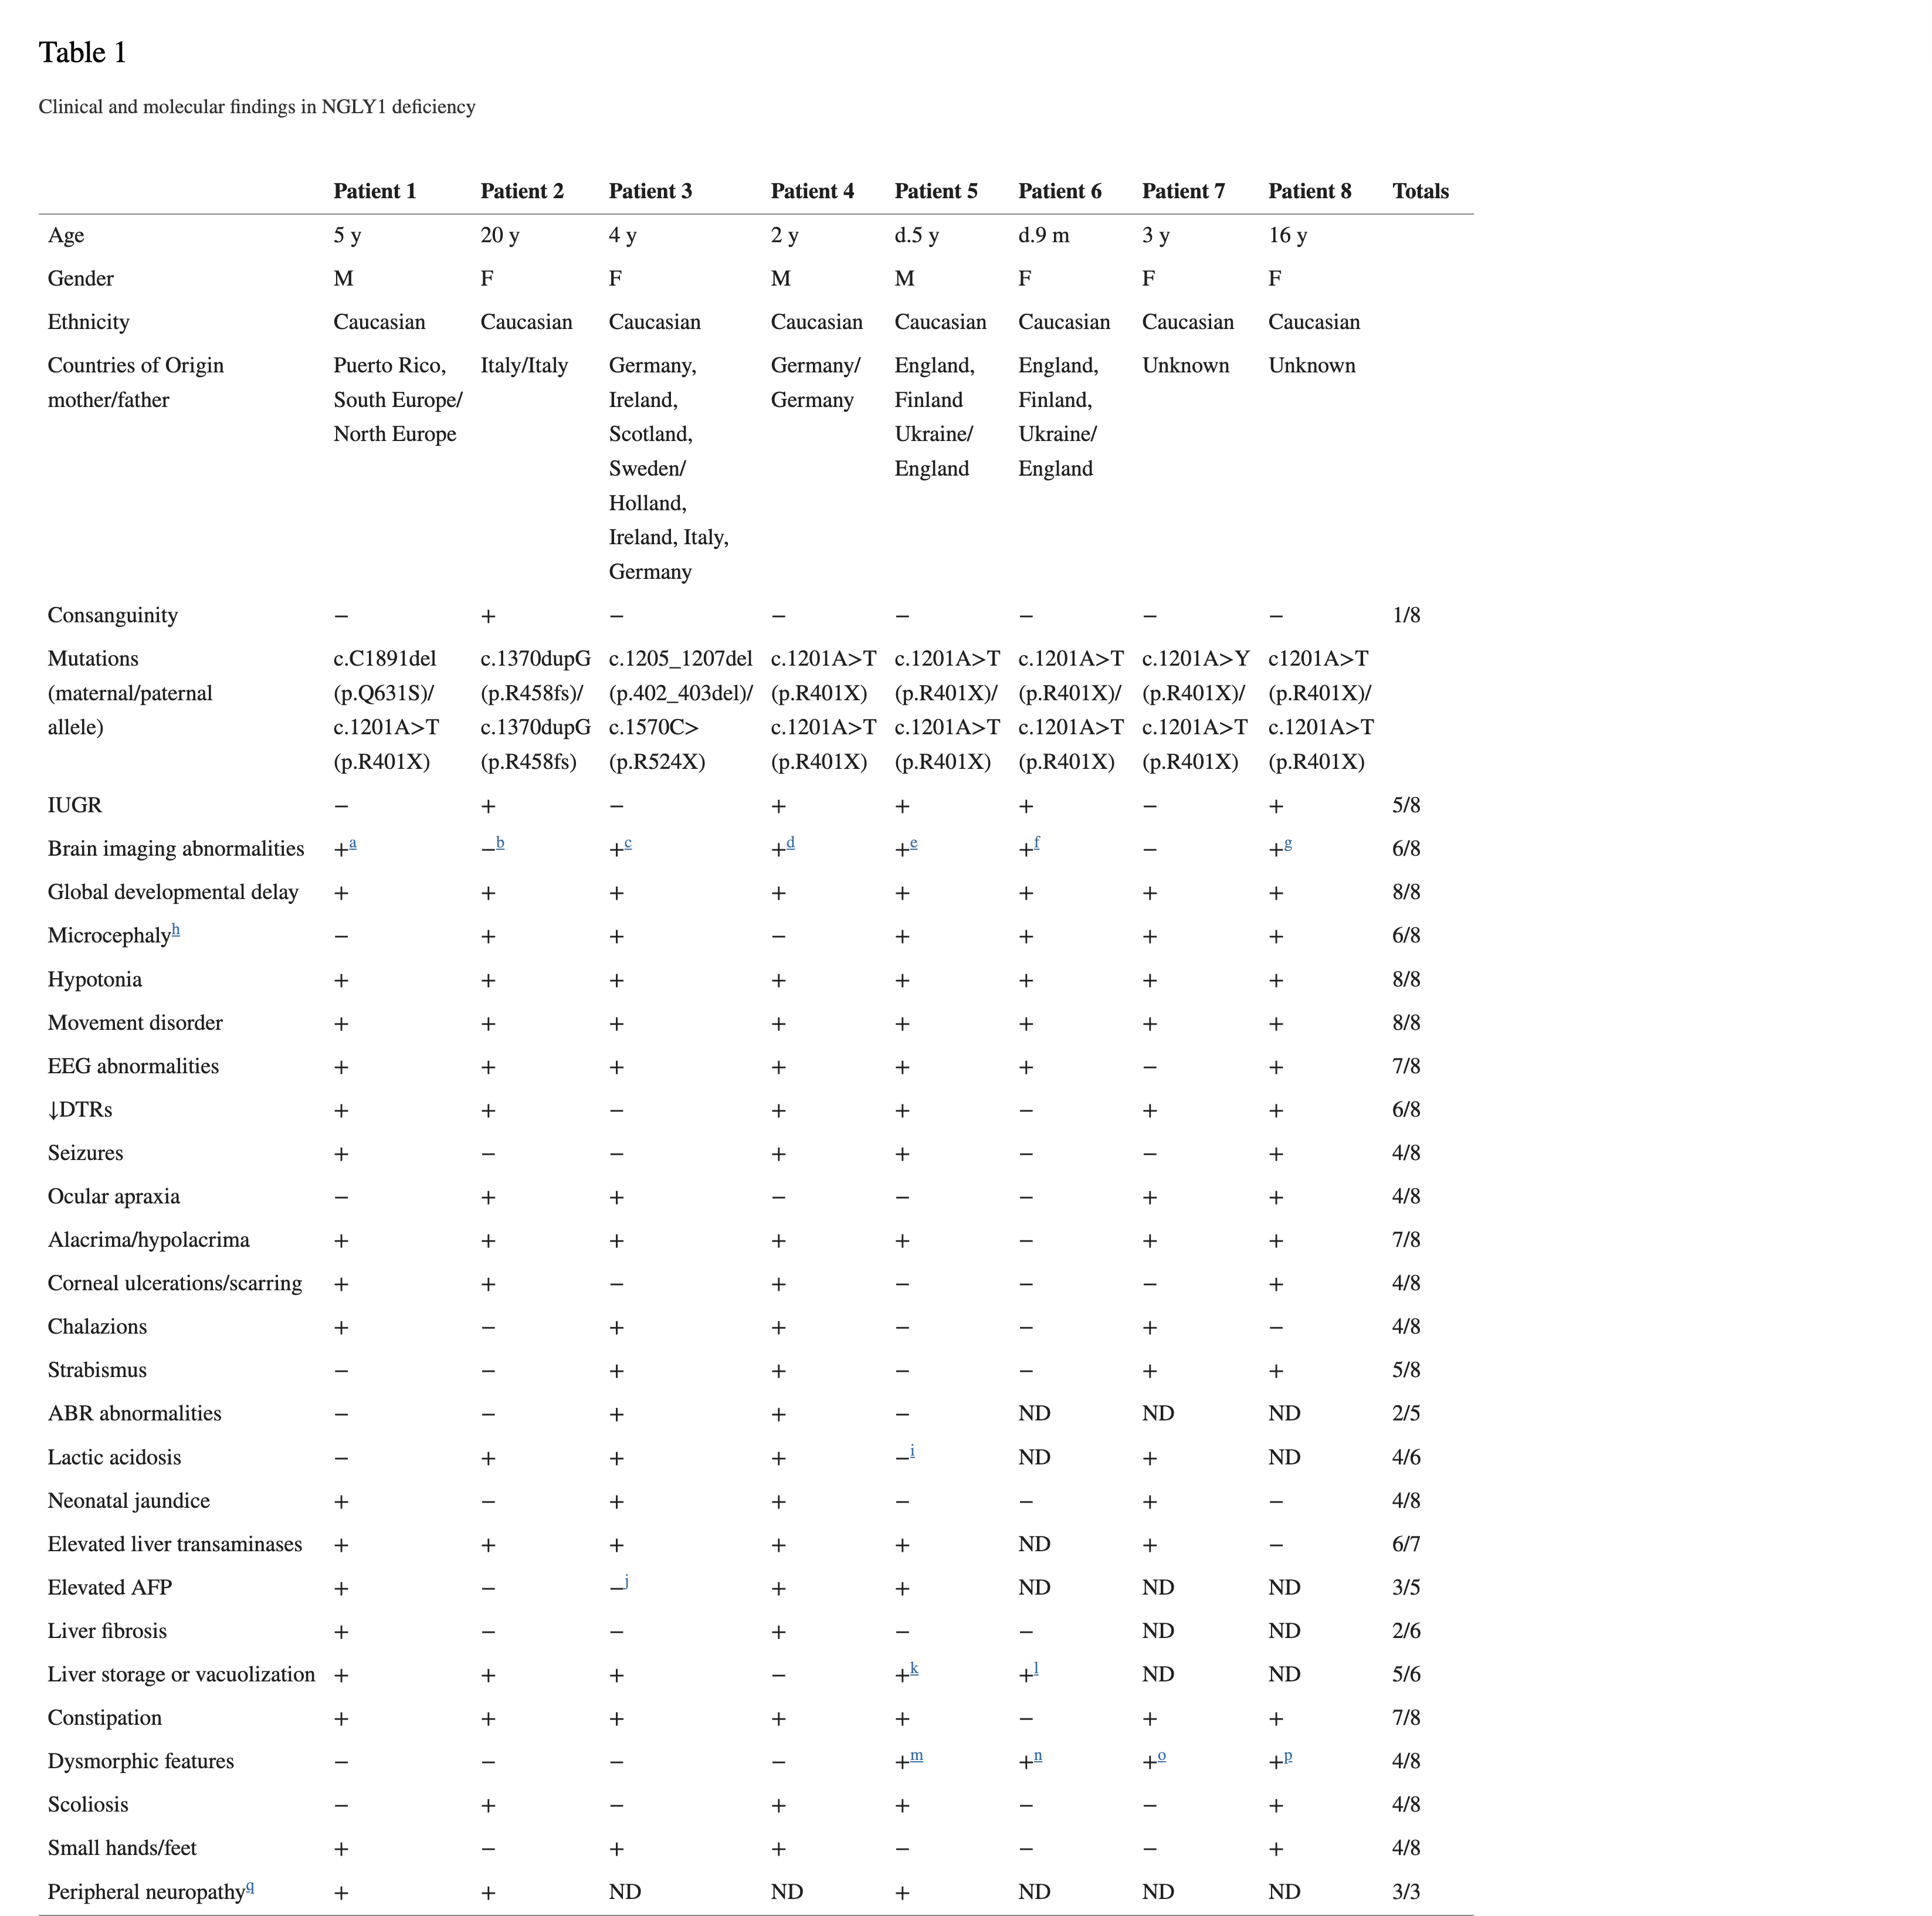

In [19]:
Image("ngly1_gpt/notebooks/images/PMC4243708_table_1.png", width=1200)

##### Phenotype Frequencies

In [27]:
phenotype_frequencies = pd.read_csv(utils.get_paths().output_data / "phenotype_frequencies.tsv", sep='\t')
phenotype_frequencies.info()
phenotype_frequencies.head(25)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   doc_id      161 non-null    object
 1   phenotype   161 non-null    object
 2   n_patients  161 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.9+ KB


,doc_id,phenotype,n_patients
0,PMC7477955,clinical seizures,7
1,PMC7477955,subclinical seizures,1
2,PMC4243708,hypotonia,8
3,PMC4243708,global developmental delay,8
4,PMC4243708,movement disorder,8
5,PMC4243708,hypo- or alacrima,7
6,PMC4243708,abnormal brain imaging,7
7,PMC4243708,EEG abnormalities,7
8,PMC4243708,elevated liver transaminases,6
9,PMC4243708,microcephaly,6


In [38]:
def apply_style(df, title):
    return (
        df
        .style
        .applymap(lambda v: utils.study_style(v), subset='study') 
        .applymap(lambda v: 'background-color: #7f7f7f; color: white', subset=['phenotype', 'all_frequencies'])
        .bar(subset=['max_frequency'], color='#17becf')
        .format('{:.1%}', subset=['max_frequency'])
        .set_caption(title)
    )

(
    phenotype_frequencies
    .pipe(lambda df: df[~df['phenotype'].str.contains('NGLY1')])
    .assign(n_study_patients=lambda df: df['doc_id'].map(study_size))
    .assign(frequency=lambda df: df['n_patients'] / df['n_study_patients'])
    .assign(frequency_str=lambda df: df.apply(lambda r: f"{r['n_patients']}/{r['n_study_patients']}", axis=1))
    .assign(study=lambda df: df['doc_id'] + ' (n=' + df['n_study_patients'].astype(str) + ')')
    .groupby(['study', 'phenotype'])
    .agg(
        all_frequencies=('frequency_str', 'unique'),
        max_frequency=('frequency', 'max'),
    )
    .assign(all_frequencies=lambda df: df['all_frequencies'].apply(lambda v: ", ".join(v)))
    .sort_values('max_frequency', ascending=False)
    .reset_index()
    .pipe(apply_style, title='Phenotype frequencies across studies')
)

,study,phenotype,all_frequencies,max_frequency
0,PMC4243708 (n=8),EEG abnormalities,"7/8, 8/8",100.0%
1,PMC4243708 (n=8),hypotonia,8/8,100.0%
2,PMC7477955 (n=12),scoliosis,"6/12, 12/12",100.0%
3,PMC7477955 (n=12),hepatopathy,12/12,100.0%
4,PMC7477955 (n=12),heart rates in the low 100s,12/12,100.0%
5,PMC4243708 (n=8),movement disorder,8/8,100.0%
6,PMC4243708 (n=8),multiple contractures,8/8,100.0%
7,PMC7477955 (n=12),global developmental delay with relatively preserved socialization,12/12,100.0%
8,PMC4243708 (n=8),profound intellectual disability,8/8,100.0%
9,PMC7477955 (n=12),decreased tear production,12/12,100.0%


In [21]:
(
    phenotype_frequencies
    # .pipe(lambda df: df[df['phenotype'] != utils.NGLY1_DEFICIENCY])
    .assign(n_study_patients=lambda df: df['doc_id'].map(study_size))
    .assign(frequency=lambda df: df['n_patients'] / df['n_study_patients'])
    .assign(frequency_str=lambda df: df.apply(lambda r: f"{r['n_patients']}/{r['n_study_patients']}", axis=1))
    .assign(study=lambda df: df['doc_id'] + ' (n=' + df['n_study_patients'].astype(str) + ')')
    .groupby(['study', 'phenotype'])
    .agg(
        all_frequencies=('frequency_str', 'unique'),
        max_frequency=('frequency', 'max'),
    )
    .assign(all_frequencies=lambda df: df['all_frequencies'].apply(lambda v: ", ".join(v)))
    .sort_values('max_frequency', ascending=False)
    .reset_index()
    .style
    .applymap(lambda v: utils.study_style(v), subset='study') 
    .applymap(lambda v: 'background-color: #7f7f7f; color: white', subset=['phenotype', 'all_frequencies'])
    .bar(subset=['max_frequency'], color='#17becf')
    .format('{:.1%}', subset=['max_frequency'])
    .set_caption('Phenotype frequencies across studies')
)

,study,phenotype,all_frequencies,max_frequency
0,PMC4243708 (n=8),EEG abnormalities,"7/8, 8/8",100.0%
1,PMC7477955 (n=12),developmental delay or intellectual disability,12/12,100.0%
2,PMC4243708 (n=8),hypotonia,8/8,100.0%
3,PMC4243708 (n=8),global developmental delay,8/8,100.0%
4,PMC7477955 (n=12),hypo- or complete alacrima,12/12,100.0%
5,PMC4243708 (n=8),constipation,8/8,100.0%
6,PMC4243708 (n=8),movement disorder,8/8,100.0%
7,PMC4243708 (n=8),alacrima/hypolacrima,8/8,100.0%
8,PMC7477955 (n=12),total foot length was < 3rd percentile,12/12,100.0%
9,PMC7477955 (n=12),corneal neovascularization,11/12,91.7%


##### Genetics

In [24]:
(
    patient_records
    .pipe(lambda df: df[df['patient_accession'] != 'ALL'])
    .assign(allele_1_mutation=lambda df: df['disease_info'].apply(lambda v: v.get('allele_1_mutation')).str.extract(r'(.*?)(?=\()'))
    .assign(allele_1_protein=lambda df: df['disease_info'].apply(lambda v: v.get('allele_1_mutation')).str.extract(r'\((.*)\)'))
    .assign(allele_2_mutation=lambda df: df['disease_info'].apply(lambda v: v.get('allele_2_mutation')).str.extract(r'(.*?)(?=\()'))
    .assign(allele_2_protein=lambda df: df['disease_info'].apply(lambda v: v.get('allele_2_mutation')).str.extract(r'\((.*)\)'))
    .assign(consanguinity=lambda df: df['consanguinity'].astype(bool))
    .assign(age=lambda df: df['age'].astype(int))
    .filter(regex='doc_id|patient_accession|age|gender|consanguinity|allele')
    .rename(columns={'doc_id': 'study'})
    .sort_values(['study', 'patient_accession'])
    .pipe(utils.apply, lambda df: display(
        df
        .style
        .set_caption('Patient demographics and mutations observed across studies')
        .applymap(lambda v: 'background-color: #7f7f7f; color: white')
        .applymap(lambda v: 'background-color: #9467bd; color: white' if v.strip() in (
            df.set_index('study').filter(regex='allele').stack().rename('value')
            .str.strip()
            .reset_index().groupby('value')['study'].nunique()
            .pipe(lambda s: s[s > 1]).index
        ) else 'background-color: #17becf; color: white', subset=df.filter(regex='allele').columns)
        .applymap(lambda v: utils.study_style(v), subset='study') 
    ))
    .pipe(utils.apply, lambda df: display(HTML("""
    <div style="background-color: #9467bd; color: white; width: 15px; display: inline-block">&nbsp</div>  Variant appears in both studies<br>
    <div style="background-color: #17becf; color: white; width: 15px; display: inline-block">&nbsp</div>  Variant appears in only one study
    """)))
);

,study,patient_accession,age,gender,consanguinity,allele_1_mutation,allele_1_protein,allele_2_mutation,allele_2_protein
0,PMC4243708,1,5,male,False,c.C1891del,p.Q631S,c.1201A>T,p.R401X
1,PMC4243708,2,20,female,True,c.1370dupG,p.R458fs,c.1370dupG,p.R458fs
2,PMC4243708,3,4,female,False,c.1205_1207del,p.402_403del,c.1570C>,p. R524X
3,PMC4243708,4,2,male,False,c.1201A>T,p.R401X,c.1201A>T,p.R401X
4,PMC4243708,5,0,male,False,c.1201A>T,p.R401X,c.1201A>T,p.R401X
5,PMC4243708,6,0,female,False,c.1201A>T,p.R401X,c.1201A>T,p.R401X
6,PMC4243708,7,3,female,False,c.1201A>Y,p. R401X,c.1201A>T,p.R401X
7,PMC4243708,8,16,female,False,c1201A>T,p. R401X,c.1201A>T,p.R401X
9,PMC7477955,1,3,male,True,c.953T>C,p.L318P,c.1169G>C,p.R390P
13,PMC7477955,2,4,male,True,c.1201A>T,p.R401*,c.1201A>T,p.R401*
